Soil moisture update for Rangpur division

In [10]:
divison = "Rajshahi"

Total records: 970
Soil moisture records (0-1 range): 485
Temperature records: 485
Soil moisture range: 0.129 to 0.497
After merging with soil moisture data: 1689 rows

Quality distribution:
Quality_Simple
Good         481
Excellent    469
Poor         441
Moderate     298
Name: count, dtype: int64

After cleaning NaN values: 1689 rows
Monthly aggregated data: 132 rows
Monthly data sample:
  Quality_Simple       Date      Mean
0      Excellent 2023-01-31  0.335721
1      Excellent 2023-02-28  0.411388
2      Excellent 2023-03-31  0.340369
3      Excellent 2023-04-30  0.219764
4      Excellent 2023-05-31  0.269411

Average soil moisture: 0.325


C:\Users\Borshon\AppData\Local\Temp\ipykernel_6356\3760849443.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stat_soil["Date"] = df_stat_soil["Date"].dt.tz_localize(None)


Plotting 132 monthly data points
Plotted 33 points for Excellent quality - range: 0.185 to 0.449
Plotted 33 points for Good quality - range: 0.186 to 0.456
Plotted 33 points for Moderate quality - range: 0.189 to 0.462
Plotted 33 points for Poor quality - range: 0.185 to 0.457


C:\Users\Borshon\AppData\Local\Temp\ipykernel_6356\3760849443.py:320: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


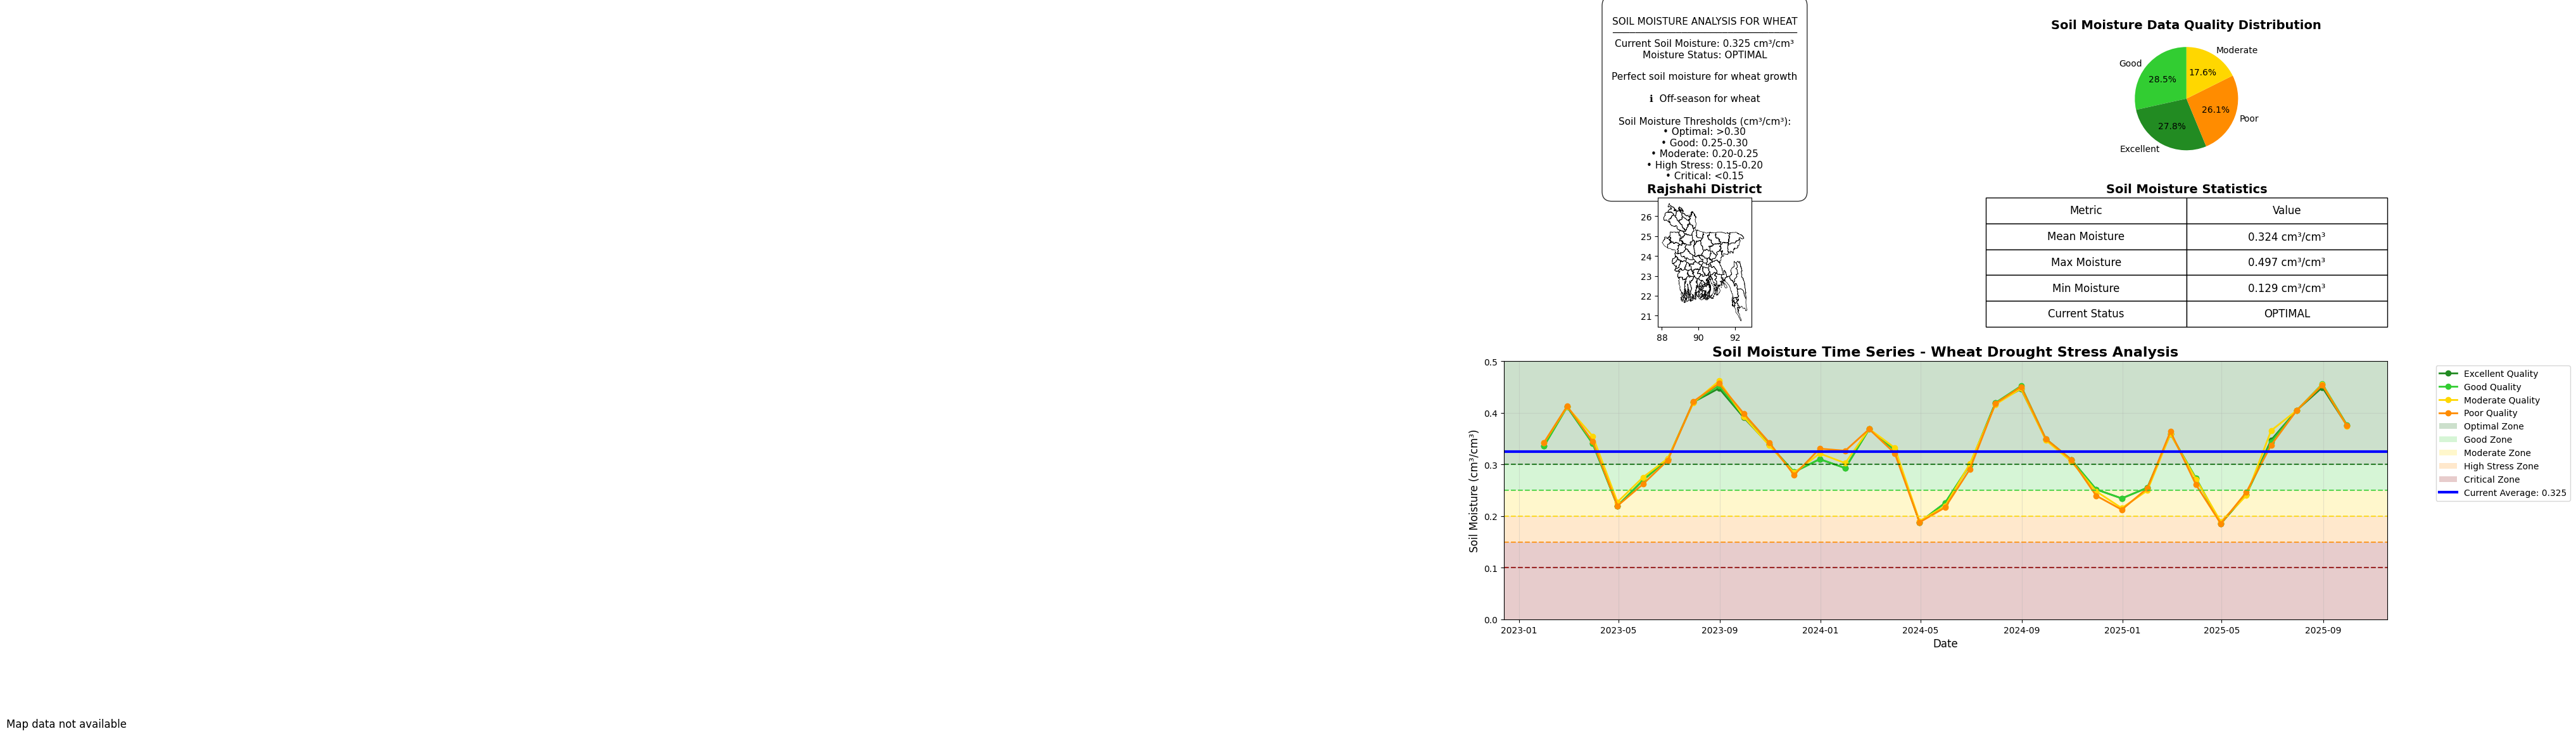


FINAL DEBUG INFORMATION
Total soil moisture records: 485
Records after merge: 1689
Records after cleaning: 1689
Monthly aggregated records: 132
Soil moisture range in monthly data: 0.185 to 0.462
Quality groups: ['Moderate', 'Excellent', 'Good', 'Poor']


In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# -------------------------
# 1. Load Data
# -------------------------
stat_file = f"{divison}/SPL3SMP-009-Statistics.csv"
flag_file = f"{divison}/SPL3SMP-009-Soil-Moisture-Retrieval-Data-AM-retrieval-qual-flag-Statistics-QA.csv"
lookup_file = f"{divison}/SPL3SMP-009-Soil-Moisture-Retrieval-Data-AM-retrieval-qual-flag-lookup.csv"

# Load CSVs
df_stat = pd.read_csv(stat_file)
df_flag = pd.read_csv(flag_file)
df_lookup = pd.read_csv(lookup_file)

# Convert Date columns
df_stat["Date"] = pd.to_datetime(df_stat["Date"], errors="coerce")
df_flag["Date"] = pd.to_datetime(df_flag["Date"], errors="coerce")

# Reshape flag data
df_flag_melted = df_flag.melt(id_vars=["File","aid","Date"], var_name="FlagCode", value_name="Count").dropna()
df_flag_melted["FlagCode"] = pd.to_numeric(df_flag_melted["FlagCode"], errors="coerce")

# Merge with lookup
df_flag_merged = df_flag_melted.merge(df_lookup, left_on="FlagCode", right_on="Value", how="left")

# -------------------------
# 2. SEPARATE SOIL MOISTURE FROM TEMPERATURE DATA
# -------------------------
# Filter for only soil moisture data (values between 0 and 1)
df_stat_slim = df_stat[["Date","Mean"]].copy()

# Identify soil moisture vs temperature data
df_stat_slim['is_soil_moisture'] = (df_stat_slim['Mean'] >= 0) & (df_stat_slim['Mean'] <= 1)
df_soil_moisture = df_stat_slim[df_stat_slim['is_soil_moisture']].copy()
df_temperature = df_stat_slim[~df_stat_slim['is_soil_moisture']].copy()

print(f"Total records: {len(df_stat_slim)}")
print(f"Soil moisture records (0-1 range): {len(df_soil_moisture)}")
print(f"Temperature records: {len(df_temperature)}")
print(f"Soil moisture range: {df_soil_moisture['Mean'].min():.3f} to {df_soil_moisture['Mean'].max():.3f}")

# Use only soil moisture data
df_stat_soil = df_soil_moisture[["Date","Mean"]]

# -------------------------
# 3. Merge with Soil Moisture Data Only
# -------------------------
df_flag_merged["Date"] = df_flag_merged["Date"].dt.tz_localize(None)
df_stat_soil["Date"] = df_stat_soil["Date"].dt.tz_localize(None)

df_all = df_flag_merged.merge(df_stat_soil, on="Date", how="inner")  # Use inner join to keep only matching dates
print(f"After merging with soil moisture data: {len(df_all)} rows")

# -------------------------
# 4. Enhanced Quality Categorization
# -------------------------
def categorize_soil_moisture_quality(row):
    flag_code = row['FlagCode']
    
    # Map based on flag codes
    if flag_code == 8:
        return "Excellent"
    elif flag_code == 9:
        return "Good"
    elif flag_code == 7:
        return "Moderate"
    elif flag_code in [13, 15]:
        return "Poor"
    else:
        return "Moderate"

df_all['Quality_Simple'] = df_all.apply(categorize_soil_moisture_quality, axis=1)

print(f"\nQuality distribution:")
print(df_all['Quality_Simple'].value_counts())

# -------------------------
# 5. Customizable Soil Moisture Thresholds for Wheat
# -------------------------
MOISTURE_THRESHOLDS = {
    'Optimal': 0.30,
    'Good': 0.25,
    'Moderate': 0.20,
    'High Stress': 0.15,
    'Critical': 0.10
}

QUALITY_COLORS = {
    'Excellent': '#228B22',
    'Good': '#32CD32',
    'Moderate': '#FFD700',
    'Poor': '#FF8C00',
    'Bad': '#DC143C'
}

MOISTURE_THRESHOLD_COLORS = {
    'Optimal': '#006400',
    'Good': '#32CD32',
    'Moderate': '#FFD700',
    'High Stress': '#FF8C00',
    'Critical': '#8B0000'
}

# -------------------------
# 6. Monthly Aggregation
# -------------------------
df_all_clean = df_all.dropna(subset=['Mean']).copy()
print(f"\nAfter cleaning NaN values: {len(df_all_clean)} rows")

if len(df_all_clean) == 0:
    print("ERROR: No valid soil moisture data!")
    exit()

df_all_clean.set_index("Date", inplace=True)

# Aggregate by month
try:
    df_monthly = df_all_clean.groupby(['Quality_Simple']).resample("ME")["Mean"].mean().reset_index()
    print(f"Monthly aggregated data: {len(df_monthly)} rows")
    print("Monthly data sample:")
    print(df_monthly.head())
except Exception as e:
    print(f"Error in monthly aggregation: {e}")
    df_monthly = df_all_clean.reset_index().groupby(['Quality_Simple', pd.Grouper(key='Date', freq='ME')])["Mean"].mean().reset_index()

# -------------------------
# 7. Enhanced Summary & Recommendation
# -------------------------
if len(df_all_clean) > 0:
    avg_moisture = df_all_clean["Mean"].mean()
else:
    avg_moisture = 0

print(f"\nAverage soil moisture: {avg_moisture:.3f}")

def get_moisture_assessment(moisture_value):
    if moisture_value >= MOISTURE_THRESHOLDS['Optimal']:
        return "OPTIMAL", "Perfect soil moisture for wheat growth"
    elif moisture_value >= MOISTURE_THRESHOLDS['Good']:
        return "GOOD", "Good soil moisture conditions"
    elif moisture_value >= MOISTURE_THRESHOLDS['Moderate']:
        return "MODERATE STRESS", "Moderate drought stress - consider irrigation"
    elif moisture_value >= MOISTURE_THRESHOLDS['High Stress']:
        return "HIGH STRESS", "High drought stress - irrigation needed"
    else:
        return "CRITICAL", "Critical drought - immediate irrigation required"

moisture_status, moisture_message = get_moisture_assessment(avg_moisture)

current_month = pd.Timestamp.now().month
if current_month in [11, 12, 1]:
    season_info = "🌱 Sowing to Early Growth"
elif current_month in [2, 3]:
    season_info = "🌾 Vegetative to Reproductive"
elif current_month in [4, 5]:
    season_info = "📈 Grain Filling to Maturity"
else:
    season_info = "ℹ️  Off-season for wheat"

summary_text = f"""
SOIL MOISTURE ANALYSIS FOR WHEAT
────────────────────────────────
Current Soil Moisture: {avg_moisture:.3f} cm³/cm³
Moisture Status: {moisture_status}

{moisture_message}

{season_info}

Soil Moisture Thresholds (cm³/cm³):
• Optimal: >{MOISTURE_THRESHOLDS['Optimal']:.2f}
• Good: {MOISTURE_THRESHOLDS['Good']:.2f}-{MOISTURE_THRESHOLDS['Optimal']:.2f}
• Moderate: {MOISTURE_THRESHOLDS['Moderate']:.2f}-{MOISTURE_THRESHOLDS['Good']:.2f}
• High Stress: {MOISTURE_THRESHOLDS['High Stress']:.2f}-{MOISTURE_THRESHOLDS['Moderate']:.2f}
• Critical: <{MOISTURE_THRESHOLDS['High Stress']:.2f}
"""

# -------------------------
# 8. Enhanced Plot Layout
# -------------------------
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 2, height_ratios=[1, 1, 2], width_ratios=[1, 1], figure=fig)

# --- Row 1, Col 1: Summary ---
ax0 = fig.add_subplot(gs[0, 0])
bg_colors = {
    'OPTIMAL': '#E8F5E8',
    'GOOD': '#F0F8E8', 
    'MODERATE STRESS': '#FFF8E1',
    'HIGH STRESS': '#FFE8E8',
    'CRITICAL': '#FFE8E8'
}
ax0.set_facecolor(bg_colors.get(moisture_status, '#FFFFFF'))
ax0.axis('off')
ax0.text(0.5, 0.5, summary_text, fontsize=11, ha='center', va='center',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=1'))

# --- Row 1, Col 2: Data Quality Distribution ---
ax1 = fig.add_subplot(gs[0, 1])
quality_counts = df_all_clean['Quality_Simple'].value_counts()
if len(quality_counts) > 0:
    colors_pie = [QUALITY_COLORS.get(q, '#999999') for q in quality_counts.index]
    ax1.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%',
            colors=colors_pie, startangle=90)
    ax1.set_title('Soil Moisture Data Quality Distribution', fontsize=14, fontweight='bold')
else:
    ax1.text(0.5, 0.5, "No quality data available", ha='center', va='center')
    ax1.set_title('Data Quality Distribution', fontsize=14, fontweight='bold')

# --- Row 2, Col 1: Map ---
ax2 = fig.add_subplot(gs[1, 0])
try:
    gdf_bgd = gpd.read_file("Bangladesh map/gadm41_BGD_2.json")
    Rangpur = gdf_bgd[gdf_bgd["NAME_2"] == "Rajshahi"]
    gdf_bgd.boundary.plot(ax=ax2, color="black", linewidth=0.5)
    moisture_colors = {
        'OPTIMAL': 'darkgreen',
        'GOOD': 'lightgreen',
        'MODERATE STRESS': 'yellow', 
        'HIGH STRESS': 'orange',
        'CRITICAL': 'red'
    }
    rajshahi.plot(ax=ax2, color=moisture_colors.get(moisture_status, 'gray'))
    ax2.set_title("Rajshahi District - Soil Moisture Level", fontsize=14, fontweight='bold')
except Exception as e:
    ax2.text(0.5, 0.5, f"Map data not available", ha='center', va='center', fontsize=12)
    ax2.set_title("Rajshahi District", fontsize=14, fontweight='bold')

# --- Row 2, Col 2: Statistics ---
ax3 = fig.add_subplot(gs[1, 1])
if len(df_soil_moisture) > 0:
    stats_data = {
        'Metric': ['Mean Moisture', 'Max Moisture', 'Min Moisture', 'Current Status'],
        'Value': [
            f"{df_soil_moisture['Mean'].mean():.3f} cm³/cm³",
            f"{df_soil_moisture['Mean'].max():.3f} cm³/cm³", 
            f"{df_soil_moisture['Mean'].min():.3f} cm³/cm³",
            moisture_status
        ]
    }
else:
    stats_data = {
        'Metric': ['Mean Moisture', 'Max Moisture', 'Min Moisture', 'Current Status'],
        'Value': ['No data', 'No data', 'No data', 'Unknown']
    }
    
stats_df = pd.DataFrame(stats_data)
ax3.axis('off')
table = ax3.table(cellText=stats_df.values,
                 colLabels=stats_df.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
ax3.set_title('Soil Moisture Statistics', fontsize=14, fontweight='bold')

# --- Row 3 (full width): Time Series ---
ax4 = fig.add_subplot(gs[2, :])

# Check if we have monthly data to plot
if len(df_monthly) > 0:
    print(f"Plotting {len(df_monthly)} monthly data points")
    
    # Plot each quality group
    for quality in df_monthly['Quality_Simple'].unique():
        group = df_monthly[df_monthly['Quality_Simple'] == quality]
        color = QUALITY_COLORS.get(quality, '#999999')
        if len(group) > 0:
            ax4.plot(group["Date"], group["Mean"], 
                    marker="o", linewidth=2, markersize=6,
                    color=color, label=f"{quality} Quality")
            print(f"Plotted {len(group)} points for {quality} quality - range: {group['Mean'].min():.3f} to {group['Mean'].max():.3f}")

    # Add threshold zones
    y_min, y_max = 0, 0.5
    threshold_ranges = [
        (MOISTURE_THRESHOLDS['Optimal'], y_max, MOISTURE_THRESHOLD_COLORS['Optimal'], 'Optimal'),
        (MOISTURE_THRESHOLDS['Good'], MOISTURE_THRESHOLDS['Optimal'], MOISTURE_THRESHOLD_COLORS['Good'], 'Good'),
        (MOISTURE_THRESHOLDS['Moderate'], MOISTURE_THRESHOLDS['Good'], MOISTURE_THRESHOLD_COLORS['Moderate'], 'Moderate'),
        (MOISTURE_THRESHOLDS['High Stress'], MOISTURE_THRESHOLDS['Moderate'], MOISTURE_THRESHOLD_COLORS['High Stress'], 'High Stress'),
        (y_min, MOISTURE_THRESHOLDS['High Stress'], MOISTURE_THRESHOLD_COLORS['Critical'], 'Critical')
    ]

    for ymin, ymax, color, label in threshold_ranges:
        ax4.axhspan(ymin, ymax, facecolor=color, alpha=0.2, label=f'{label} Zone')

    # Add threshold lines
    for threshold_name, threshold_value in MOISTURE_THRESHOLDS.items():
        ax4.axhline(y=threshold_value, color=MOISTURE_THRESHOLD_COLORS[threshold_name], 
                    linestyle='--', alpha=0.8, linewidth=1.5)

    # Add current average line
    ax4.axhline(y=avg_moisture, color='blue', linestyle='-', linewidth=3, 
               label=f'Current Average: {avg_moisture:.3f}')
    
    ax4.set_ylim(y_min, y_max)
else:
    # If no monthly data, try to plot raw data
    print("No monthly data available, trying raw data...")
    for quality in df_all_clean['Quality_Simple'].unique():
        group = df_all_clean[df_all_clean['Quality_Simple'] == quality]
        color = QUALITY_COLORS.get(quality, '#999999')
        if len(group) > 0:
            ax4.scatter(group.index, group["Mean"], 
                       color=color, label=f"{quality} Quality", s=50, alpha=0.7)

ax4.set_title("Soil Moisture Time Series - Wheat Drought Stress Analysis", 
             fontsize=16, fontweight='bold')
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Soil Moisture (cm³/cm³)", fontsize=12)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------
# 9. Final Debug Information
# -------------------------
print("\n" + "="*50)
print("FINAL DEBUG INFORMATION")
print("="*50)
print(f"Total soil moisture records: {len(df_soil_moisture)}")
print(f"Records after merge: {len(df_all)}")
print(f"Records after cleaning: {len(df_all_clean)}")
print(f"Monthly aggregated records: {len(df_monthly)}")
if len(df_monthly) > 0:
    print(f"Soil moisture range in monthly data: {df_monthly['Mean'].min():.3f} to {df_monthly['Mean'].max():.3f}")
print(f"Quality groups: {df_all_clean['Quality_Simple'].unique().tolist()}")

Temperature stats based on day and night for heat stress

C:\Users\Borshon\AppData\Local\Temp\ipykernel_6356\214042904.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stat_slim["Date"] = df_stat_slim["Date"].dt.tz_localize(None)
C:\Users\Borshon\AppData\Local\Temp\ipykernel_6356\214042904.py:124: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_all.groupby(["FlagCode","Quality_Simple"]).resample("M")["Mean"].mean().reset_index()


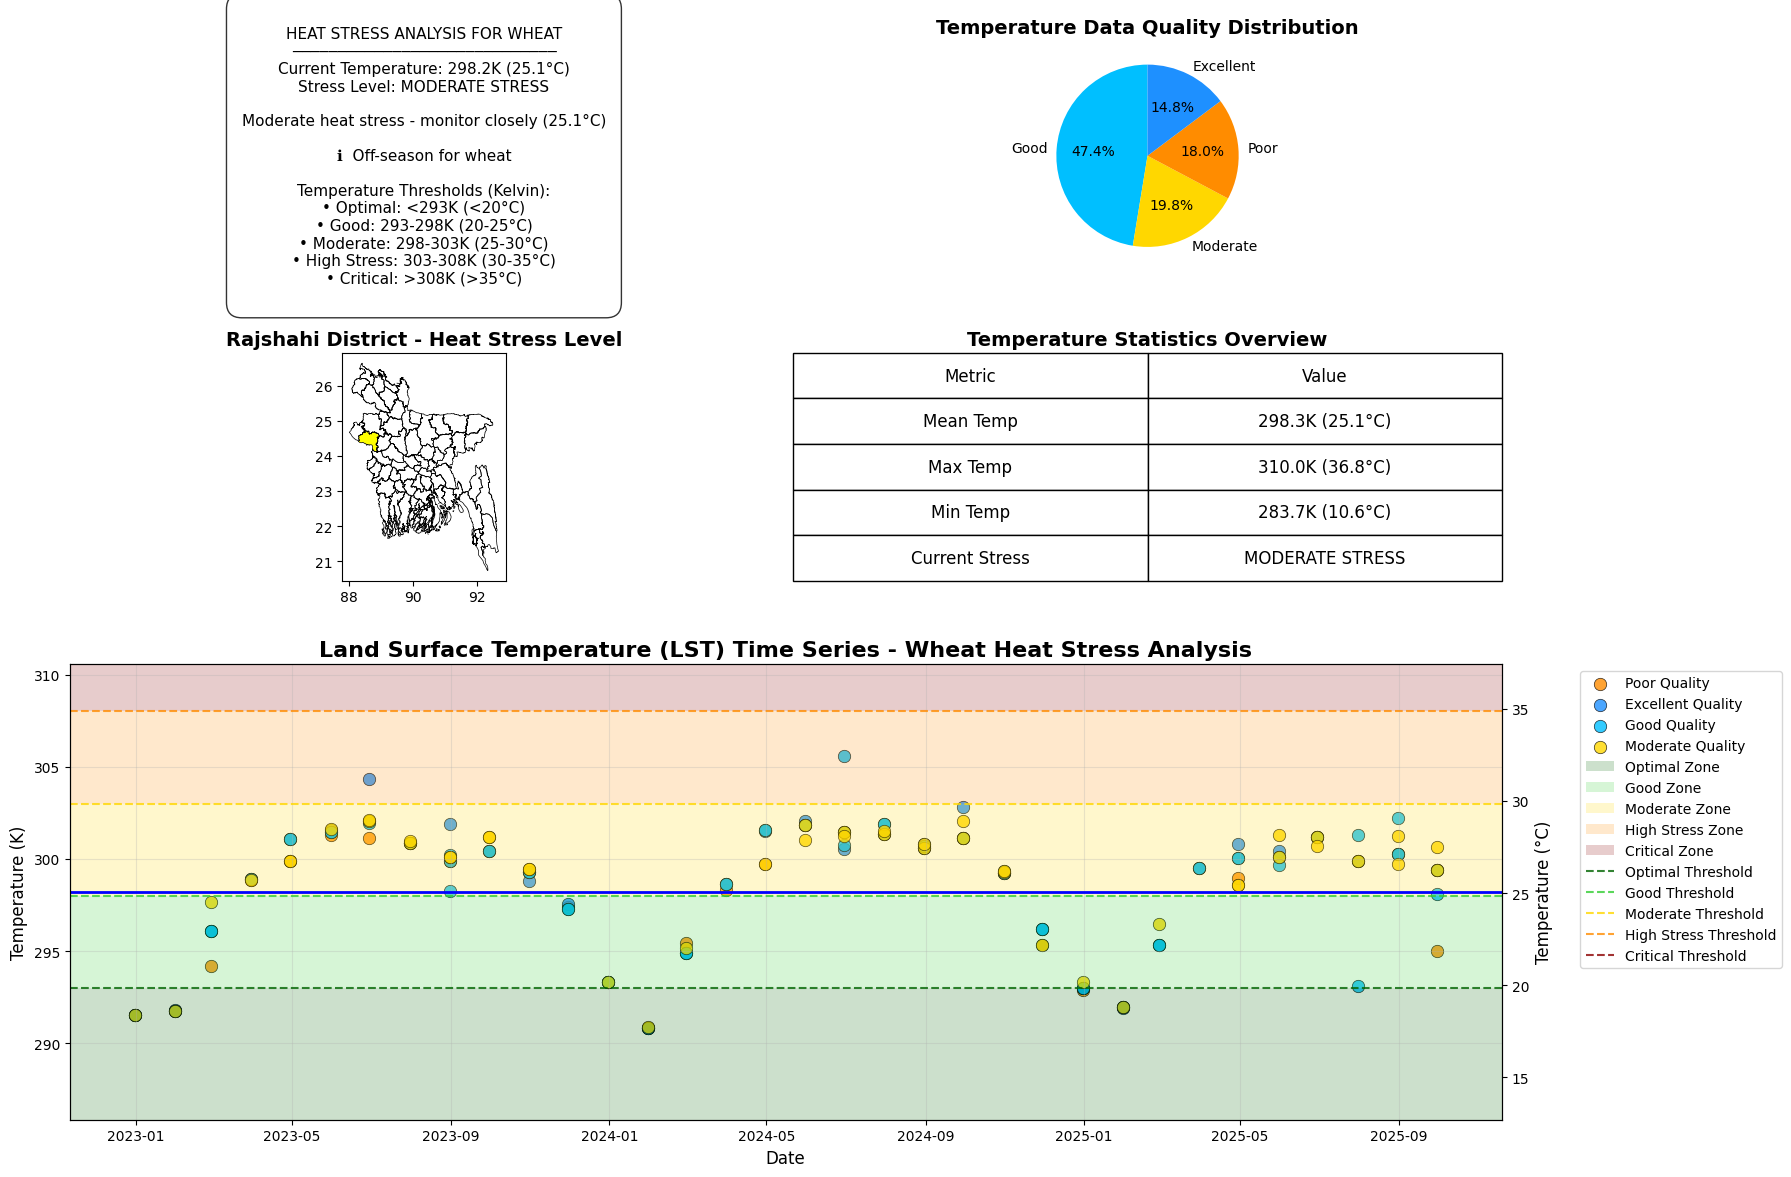


DETAILED HEAT STRESS ANALYSIS REPORT

🌡️ TEMPERATURE STATISTICS:
   Average Temperature: 298.3K (25.1°C)
   Maximum Temperature: 310.0K (36.8°C)
   Minimum Temperature: 283.7K (10.6°C)
   Standard Deviation: 1.6K

🎯 STRESS ASSESSMENT: MODERATE STRESS
   Moderate heat stress - monitor closely (25.1°C)

📈 DATA QUALITY DISTRIBUTION:
   Good: 469 records (47.4%)
   Moderate: 196 records (19.8%)
   Poor: 178 records (18.0%)
   Excellent: 146 records (14.8%)

🌾 SEASONAL CONTEXT:
   ℹ️  Off-season for wheat

💡 RECOMMENDATIONS:
   • Increase irrigation frequency
   • Monitor for heat stress symptoms
   • Consider shade management if possible

⚠️  IMPACT ON WHEAT:
   • Normal growth and development
   • Optimal yield potential


In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# -------------------------
# 1. Load Temperature Data
# -------------------------
stat_file = f"{divison}/MYD11A2-061-Statistics.csv"
qc_day_file = f"{divison}/MYD11A2-061-QC-Day-Statistics-QA.csv"
qc_day_lookup_file = f"{divison}/MYD11A2-061-QC-Day-lookup.csv"

# Load CSVs
df_stat = pd.read_csv(stat_file)
df_qc_day = pd.read_csv(qc_day_file)
df_qc_lookup = pd.read_csv(qc_day_lookup_file)

# Convert Date columns
df_stat["Date"] = pd.to_datetime(df_stat["Date"], errors="coerce")
df_qc_day["Date"] = pd.to_datetime(df_qc_day["Date"], errors="coerce")

# -------------------------
# 2. Reshape QC Data
# -------------------------
df_qc_melted = df_qc_day.melt(id_vars=["File","aid","Date"], var_name="FlagCode", value_name="Count").dropna()
df_qc_melted["FlagCode"] = pd.to_numeric(df_qc_melted["FlagCode"], errors="coerce")

# Merge with QC lookup to get descriptions
df_qc_merged = df_qc_melted.merge(df_qc_lookup, left_on="FlagCode", right_on="Value", how="left")

# -------------------------
# 3. Merge with Temperature Statistics
# -------------------------
df_stat_slim = df_stat[["Date","Mean"]]
df_qc_merged["Date"] = df_qc_merged["Date"].dt.tz_localize(None)
df_stat_slim["Date"] = df_stat_slim["Date"].dt.tz_localize(None)
df_all = df_qc_merged.merge(df_stat_slim, on="Date", how="left")

# -------------------------
# 4. Enhanced QC Flag Categorization for Temperature Quality
# -------------------------
def categorize_temperature_quality(row):
    # Assuming temperature QC has similar structure - adjust based on your actual QC columns
    # You may need to modify this based on your actual temperature QC lookup structure
    flag_code = row['FlagCode']
    
    # High quality temperature data
    if flag_code in [17, 1, 0]:  # Adjust based on your actual good quality flags
        return "Excellent"
    # Good quality 
    elif flag_code in [65, 81, 97]:  # Adjust based on your actual moderate quality flags
        return "Good"
    # Moderate quality
    elif flag_code in [129, 145]:  # Adjust based on your actual poor quality flags
        return "Moderate"
    # Poor quality
    elif flag_code in [2, 161]:  # Adjust based on your actual bad quality flags
        return "Poor"
    else:
        return "Moderate"

# If you have detailed QC descriptions, use this enhanced version:
def enhanced_temperature_quality(row):
    # Check if the QC lookup has specific columns for temperature
    qc_description = str(row.get('Description', '')).lower() if 'Description' in row else ''
    mandatory_qa = str(row.get('Mandatory QA', '')).lower() if 'Mandatory QA' in row else ''
    
    # High quality - clear sky, good data
    if ('good' in qc_description or 'clear' in qc_description or 
        mandatory_qa in ['00', '01']):  # Adjust based on your QC
        return "Excellent"
    # Good quality - some limitations but usable
    elif ('average' in qc_description or 'usable' in qc_description or
          mandatory_qa in ['10', '11']):
        return "Good"
    # Moderate quality - needs checking
    elif ('check' in qc_description or 'caution' in qc_description or
          mandatory_qa in ['20', '21']):
        return "Moderate"
    # Poor quality - cloudy or bad data
    elif ('cloudy' in qc_description or 'bad' in qc_description or
          mandatory_qa in ['30', '31']):
        return "Poor"
    else:
        return "Moderate"

# Use the appropriate function based on your data
df_all['Quality_Simple'] = df_all.apply(categorize_temperature_quality, axis=1)

# -------------------------
# 5. Customizable Temperature Thresholds for Wheat
# -------------------------
# Temperature thresholds in Kelvin for wheat crop
TEMP_THRESHOLDS = {
    'Optimal': 293,      # ~20°C - Optimal for wheat growth
    'Good': 298,         # ~25°C - Good for growth
    'Moderate': 303,     # ~30°C - Moderate heat stress
    'High Stress': 308,  # ~35°C - High heat stress
    'Critical': 313      # ~40°C - Critical for wheat
}

# Color schemes for different elements
QUALITY_COLORS = {
    'Excellent': '#1E90FF',      # Dodger Blue
    'Good': '#00BFFF',           # Deep Sky Blue
    'Moderate': '#FFD700',       # Gold
    'Poor': '#FF8C00',           # Dark Orange
    'Bad': '#DC143C'             # Crimson
}

TEMP_THRESHOLD_COLORS = {
    'Optimal': '#006400',        # Dark Green
    'Good': '#32CD32',           # Lime Green
    'Moderate': '#FFD700',       # Gold
    'High Stress': '#FF8C00',    # Dark Orange
    'Critical': '#8B0000'        # Dark Red
}

# -------------------------
# 6. Monthly Aggregation
# -------------------------
df_all.set_index("Date", inplace=True)
df_monthly = df_all.groupby(["FlagCode","Quality_Simple"]).resample("M")["Mean"].mean().reset_index()

# -------------------------
# 7. Enhanced Summary & Recommendation for Heat Stress
# -------------------------
def get_heat_stress_assessment(temp_kelvin):
    temp_celsius = temp_kelvin - 273.15  # Convert to Celsius for interpretation
    
    if temp_kelvin <= TEMP_THRESHOLDS['Optimal']:
        return "OPTIMAL", f"Perfect temperature for wheat growth ({temp_celsius:.1f}°C)"
    elif temp_kelvin <= TEMP_THRESHOLDS['Good']:
        return "GOOD", f"Good conditions for wheat ({temp_celsius:.1f}°C)"
    elif temp_kelvin <= TEMP_THRESHOLDS['Moderate']:
        return "MODERATE STRESS", f"Moderate heat stress - monitor closely ({temp_celsius:.1f}°C)"
    elif temp_kelvin <= TEMP_THRESHOLDS['High Stress']:
        return "HIGH STRESS", f"High heat stress - irrigation needed ({temp_celsius:.1f}°C)"
    else:
        return "CRITICAL", f"Critical heat stress - crop damage likely ({temp_celsius:.1f}°C)"

avg_temp = df_all["Mean"].mean()
stress_status, stress_message = get_heat_stress_assessment(avg_temp)

# Seasonal context
current_month = pd.Timestamp.now().month
season_info = ""
if current_month in [11, 12, 1, 2]:  # Rabi season
    season_info = "🌾 Rabi Season (Critical growth phase)"
elif current_month in [3, 4]:  # Harvest
    season_info = "🔴 Harvest Period (Avoid high temperatures)"
else:
    season_info = "ℹ️  Off-season for wheat"

summary_text = f"""
HEAT STRESS ANALYSIS FOR WHEAT
─────────────────────────────
Current Temperature: {avg_temp:.1f}K ({(avg_temp-273.15):.1f}°C)
Stress Level: {stress_status}

{stress_message}

{season_info}

Temperature Thresholds (Kelvin):
• Optimal: <{TEMP_THRESHOLDS['Optimal']}K (<20°C)
• Good: {TEMP_THRESHOLDS['Optimal']}-{TEMP_THRESHOLDS['Good']}K (20-25°C)
• Moderate: {TEMP_THRESHOLDS['Good']}-{TEMP_THRESHOLDS['Moderate']}K (25-30°C)
• High Stress: {TEMP_THRESHOLDS['Moderate']}-{TEMP_THRESHOLDS['High Stress']}K (30-35°C)
• Critical: >{TEMP_THRESHOLDS['High Stress']}K (>35°C)
"""

# -------------------------
# 8. Enhanced Plot Layout with Custom Colors
# -------------------------
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 2, height_ratios=[1, 1, 2], width_ratios=[1, 1], figure=fig)

# --- Row 1, Col 1: Summary with colored background ---
ax0 = fig.add_subplot(gs[0, 0])
# Set background color based on stress status
bg_colors = {
    'OPTIMAL': '#E8F5E8',
    'GOOD': '#F0F8E8', 
    'MODERATE STRESS': '#FFF8E1',
    'HIGH STRESS': '#FFE8E8',
    'CRITICAL': '#FFE8E8'
}
ax0.set_facecolor(bg_colors.get(stress_status, '#FFFFFF'))
ax0.axis('off')
ax0.text(0.5, 0.5, summary_text, fontsize=11, ha='center', va='center',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=1'))

# --- Row 1, Col 2: Data Quality Distribution ---
ax1 = fig.add_subplot(gs[0, 1])
quality_counts = df_all['Quality_Simple'].value_counts()
colors_pie = [QUALITY_COLORS.get(q, '#999999') for q in quality_counts.index]
ax1.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax1.set_title('Temperature Data Quality Distribution', fontsize=14, fontweight='bold')

# --- Row 2, Col 1: Map ---
ax2 = fig.add_subplot(gs[1, 0])
try:
    gdf_bgd = gpd.read_file("Bangladesh map/gadm41_BGD_2.json")
    rajshahi = gdf_bgd[gdf_bgd["NAME_2"] == "Rajshahi"]
    gdf_bgd.boundary.plot(ax=ax2, color="black", linewidth=0.5)
    
    # Color map based on stress level
    stress_colors = {
        'OPTIMAL': 'green',
        'GOOD': 'lightgreen',
        'MODERATE STRESS': 'yellow', 
        'HIGH STRESS': 'orange',
        'CRITICAL': 'red'
    }
    rajshahi.plot(ax=ax2, color=stress_colors.get(stress_status, 'gray'))
    ax2.set_title("Rajshahi District - Heat Stress Level", fontsize=14, fontweight='bold')
except Exception as e:
    ax2.text(0.5, 0.5, f"Map data not available\nError: {str(e)}", 
             ha='center', va='center', fontsize=12)
    ax2.set_title("Rajshahi District", fontsize=14, fontweight='bold')

# --- Row 2, Col 2: Temperature Statistics ---
ax3 = fig.add_subplot(gs[1, 1])
stats_data = {
    'Metric': ['Mean Temp', 'Max Temp', 'Min Temp', 'Current Stress'],
    'Value': [
        f"{df_stat['Mean'].mean():.1f}K ({(df_stat['Mean'].mean()-273.15):.1f}°C)",
        f"{df_stat['Mean'].max():.1f}K ({(df_stat['Mean'].max()-273.15):.1f}°C)", 
        f"{df_stat['Mean'].min():.1f}K ({(df_stat['Mean'].min()-273.15):.1f}°C)",
        stress_status
    ]
}
stats_df = pd.DataFrame(stats_data)
ax3.axis('off')
table = ax3.table(cellText=stats_df.values,
                 colLabels=stats_df.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
ax3.set_title('Temperature Statistics Overview', fontsize=14, fontweight='bold')

# --- Row 3 (full width): Enhanced Temperature Time Series ---
ax4 = fig.add_subplot(gs[2, :])

# Plot data points with quality-based colors
for quality in df_monthly['Quality_Simple'].unique():
    group = df_monthly[df_monthly['Quality_Simple'] == quality]
    color = QUALITY_COLORS.get(quality, '#999999')
    ax4.scatter(group["Date"], group["Mean"], 
               c=color, label=f"{quality} Quality", 
               s=80, alpha=0.8, edgecolors='black', linewidth=0.5)

# Add shaded regions for temperature thresholds
y_min, y_max = df_monthly["Mean"].min() - 5, df_monthly["Mean"].max() + 5
threshold_ranges = [
    (y_min, TEMP_THRESHOLDS['Optimal'], TEMP_THRESHOLD_COLORS['Optimal'], 'Optimal'),
    (TEMP_THRESHOLDS['Optimal'], TEMP_THRESHOLDS['Good'], TEMP_THRESHOLD_COLORS['Good'], 'Good'),
    (TEMP_THRESHOLDS['Good'], TEMP_THRESHOLDS['Moderate'], TEMP_THRESHOLD_COLORS['Moderate'], 'Moderate'),
    (TEMP_THRESHOLDS['Moderate'], TEMP_THRESHOLDS['High Stress'], TEMP_THRESHOLD_COLORS['High Stress'], 'High Stress'),
    (TEMP_THRESHOLDS['High Stress'], y_max, TEMP_THRESHOLD_COLORS['Critical'], 'Critical')
]

for ymin, ymax, color, label in threshold_ranges:
    ax4.axhspan(ymin, ymax, facecolor=color, alpha=0.2, label=f'{label} Zone')

# Add threshold lines
for threshold_name, threshold_value in TEMP_THRESHOLDS.items():
    ax4.axhline(y=threshold_value, color=TEMP_THRESHOLD_COLORS[threshold_name], 
                linestyle='--', alpha=0.8, linewidth=1.5,
                label=f'{threshold_name} Threshold')

ax4.set_title("Land Surface Temperature (LST) Time Series - Wheat Heat Stress Analysis", 
             fontsize=16, fontweight='bold')
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Temperature (K)", fontsize=12)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(y_min, y_max)

# Add current average line
ax4.axhline(y=avg_temp, color='blue', linestyle='-', linewidth=2, 
           label=f'Current Average: {avg_temp:.1f}K')

# Add secondary y-axis for Celsius
ax4_celsius = ax4.twinx()
kelvin_ticks = ax4.get_yticks()
celsius_ticks = kelvin_ticks - 273.15
ax4_celsius.set_ylim(ax4.get_ylim()[0]-273.15, ax4.get_ylim()[1]-273.15)
ax4_celsius.set_ylabel("Temperature (°C)", fontsize=12)

plt.tight_layout()
plt.show()

# -------------------------
# 9. Detailed Heat Stress Report
# -------------------------
print("\n" + "="*50)
print("DETAILED HEAT STRESS ANALYSIS REPORT")
print("="*50)

print(f"\n🌡️ TEMPERATURE STATISTICS:")
print(f"   Average Temperature: {df_stat['Mean'].mean():.1f}K ({(df_stat['Mean'].mean()-273.15):.1f}°C)")
print(f"   Maximum Temperature: {df_stat['Mean'].max():.1f}K ({(df_stat['Mean'].max()-273.15):.1f}°C)")
print(f"   Minimum Temperature: {df_stat['Mean'].min():.1f}K ({(df_stat['Mean'].min()-273.15):.1f}°C)")
print(f"   Standard Deviation: {df_stat['Standard Deviation'].mean():.1f}K")

print(f"\n🎯 STRESS ASSESSMENT: {stress_status}")
print(f"   {stress_message}")

print(f"\n📈 DATA QUALITY DISTRIBUTION:")
total_records = len(df_all)
for quality, count in df_all['Quality_Simple'].value_counts().items():
    percentage = (count / total_records) * 100
    color_code = QUALITY_COLORS.get(quality, '')
    print(f"   {quality}: {count} records ({percentage:.1f}%)")

print(f"\n🌾 SEASONAL CONTEXT:")
print(f"   {season_info}")

print(f"\n💡 RECOMMENDATIONS:")
if stress_status == "OPTIMAL":
    print("   • Ideal conditions for wheat growth")
    print("   • Maintain current irrigation schedule")
elif stress_status == "GOOD":
    print("   • Good growing conditions")
    print("   • Monitor soil moisture")
elif stress_status == "MODERATE STRESS":
    print("   • Increase irrigation frequency")
    print("   • Monitor for heat stress symptoms")
    print("   • Consider shade management if possible")
elif stress_status == "HIGH STRESS":
    print("   • Implement cooling irrigation")
    print("   • Avoid midday operations")
    print("   • Monitor crop health closely")
else:  # CRITICAL
    print("   • URGENT: Implement emergency cooling measures")
    print("   • Increase irrigation significantly")
    print("   • Consider harvest timing adjustments")
    print("   • Monitor for heat-induced diseases")

print(f"\n⚠️  IMPACT ON WHEAT:")
if stress_status in ["HIGH STRESS", "CRITICAL"]:
    print("   • Reduced photosynthesis efficiency")
    print("   • Potential yield loss")
    print("   • Increased water requirement")
    print("   • Risk of heat-induced sterility")
else:
    print("   • Normal growth and development")
    print("   • Optimal yield potential")

Vegetation details for wheat health

C:\Users\Borshon\AppData\Local\Temp\ipykernel_6356\2021880280.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stat_slim["Date"] = df_stat_slim["Date"].dt.tz_localize(None)
C:\Users\Borshon\AppData\Local\Temp\ipykernel_6356\2021880280.py:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_all.groupby(["FlagCode","Quality_Simple"]).resample("M")["Mean"].mean().reset_index()


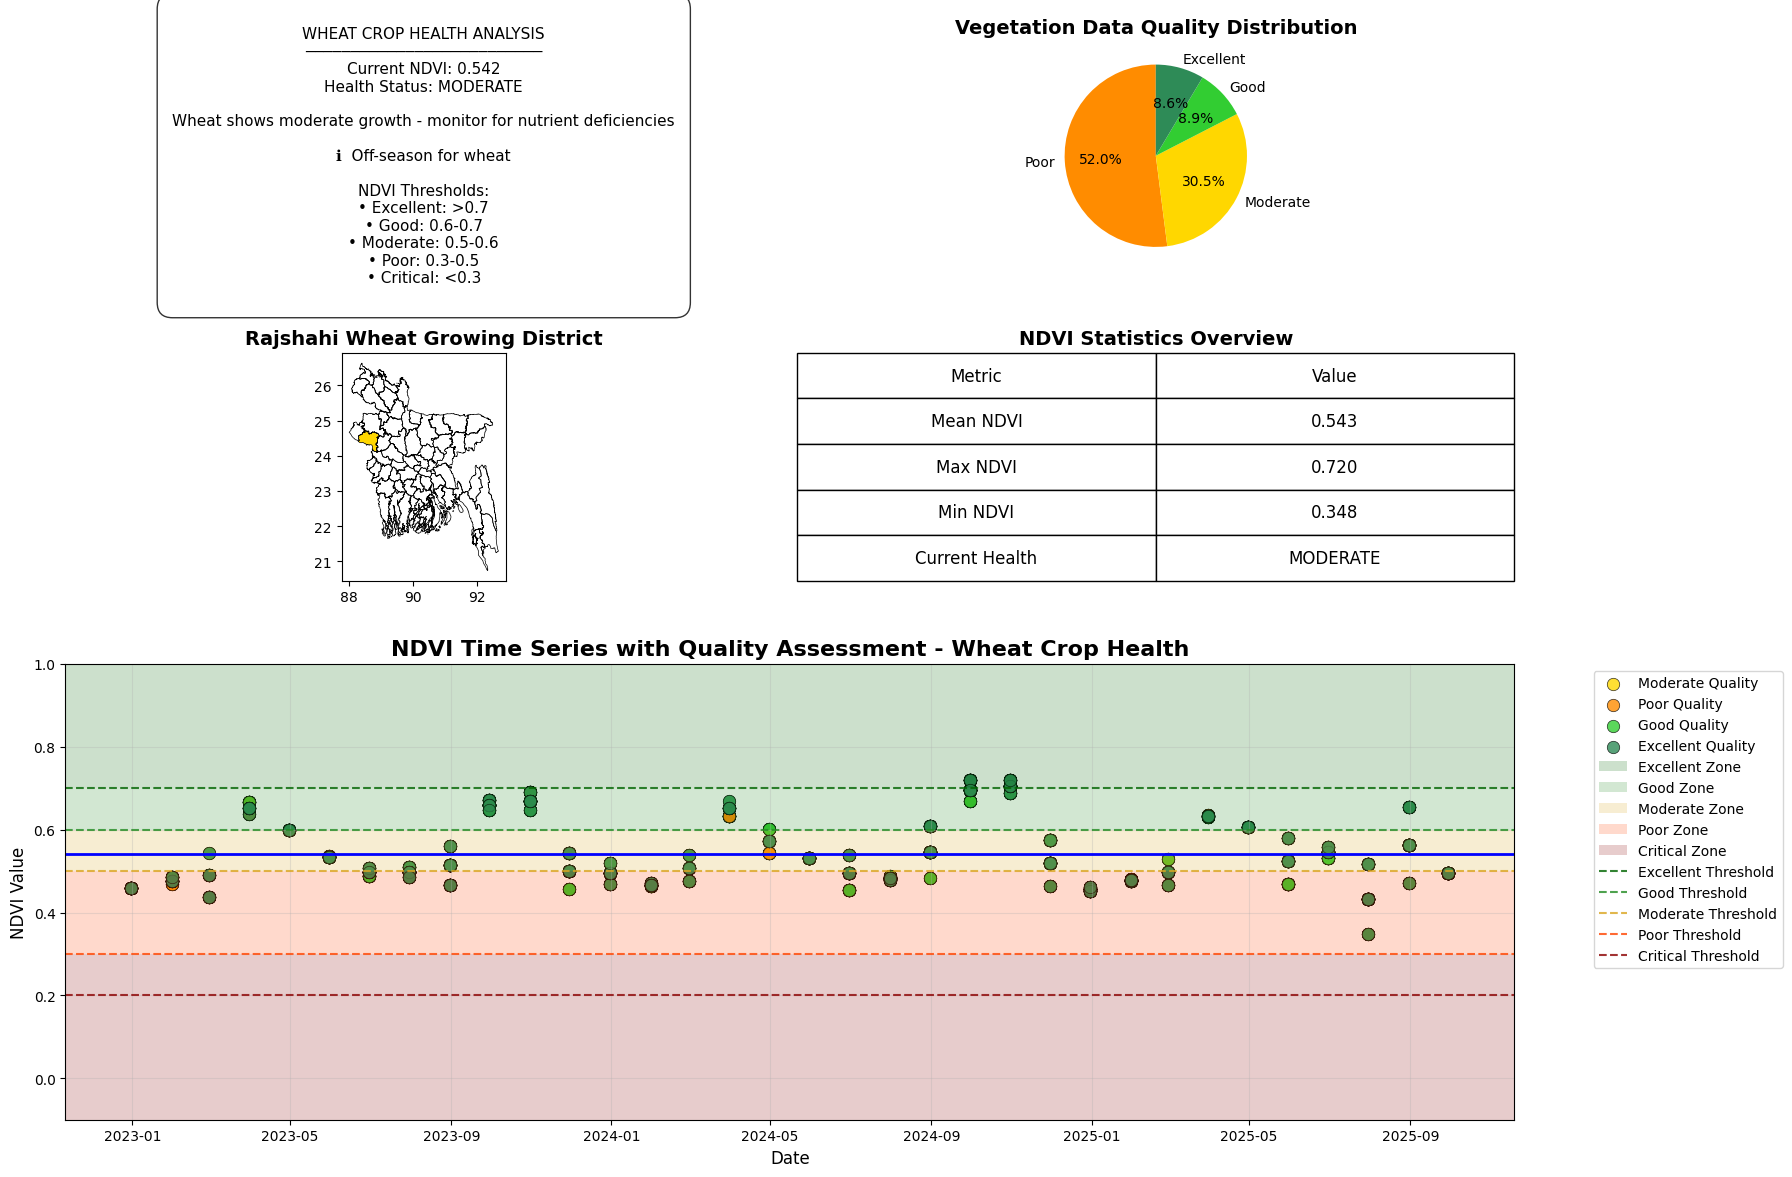


DETAILED WHEAT CROP HEALTH REPORT

📊 VEGETATION INDICES:
   Average NDVI: 0.543
   Maximum NDVI: 0.720
   Minimum NDVI: 0.348
   Standard Deviation: 0.156

🎯 HEALTH ASSESSMENT: MODERATE
   Wheat shows moderate growth - monitor for nutrient deficiencies

📈 DATA QUALITY DISTRIBUTION:
   Poor: 3404 records (52.0%)
   Moderate: 1999 records (30.5%)
   Good: 580 records (8.9%)
   Excellent: 561 records (8.6%)

🌾 SEASONAL CONTEXT:
   ℹ️  Off-season for wheat

💡 RECOMMENDATIONS:
   • Check soil nutrients
   • Increase monitoring frequency
   • Consider soil testing


In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# -------------------------
# 1. Load Vegetation Data
# -------------------------
stat_file = f"{divison}/MOD13Q1-061-Statistics.csv"
qc_file = f"{divison}/MOD13Q1-061-250m-16-days-VI-Quality-Statistics-QA.csv"
qc_lookup_file = f"{divison}/MOD13Q1-061-250m-16-days-VI-Quality-lookup.csv"

# Load CSVs
df_stat = pd.read_csv(stat_file)
df_qc = pd.read_csv(qc_file)
df_qc_lookup = pd.read_csv(qc_lookup_file)

# Convert Date columns
df_stat["Date"] = pd.to_datetime(df_stat["Date"], errors="coerce")
df_qc["Date"] = pd.to_datetime(df_qc["Date"], errors="coerce")

# -------------------------
# 2. Reshape QC Data
# -------------------------
df_qc_melted = df_qc.melt(id_vars=["File","aid","Date"], var_name="FlagCode", value_name="Count").dropna()
df_qc_melted["FlagCode"] = pd.to_numeric(df_qc_melted["FlagCode"], errors="coerce")

# Merge with QC lookup to get descriptions
df_qc_merged = df_qc_melted.merge(df_qc_lookup, left_on="FlagCode", right_on="Value", how="left")

# -------------------------
# 3. Merge with Vegetation Statistics
# -------------------------
df_stat_slim = df_stat[["Date","Mean"]]
df_qc_merged["Date"] = df_qc_merged["Date"].dt.tz_localize(None)
df_stat_slim["Date"] = df_stat_slim["Date"].dt.tz_localize(None)
df_all = df_qc_merged.merge(df_stat_slim, on="Date", how="left")

# -------------------------
# 4. Enhanced QC Flag Categorization for Vegetation Quality
# -------------------------
def categorize_vegetation_quality(row):
    modland = str(row['MODLAND']).lower()
    vi_usefulness = str(row['VI Usefulness']).lower()
    aerosol = str(row['Aerosol Quantity']).lower()
    clouds = str(row['Adjacent cloud detected']).lower()
    
    # High quality - good VI with low aerosol
    if ('good quality' in modland and 
        'low' in aerosol and 
        'no' in clouds):
        return "Excellent"
    # Good quality - produced with some limitations
    elif ('produced' in modland and 
          'decreasing quality' not in vi_usefulness and
          'no' in clouds):
        return "Good"
    # Moderate quality - produced but needs checking or average aerosol
    elif ('produced' in modland and 
          ('check' in modland or 'average' in aerosol)):
        return "Moderate"
    # Poor quality - cloudy, high aerosol, or mixed clouds
    elif ('cloudy' in modland or 
          'high' in aerosol or 
          'yes' in clouds or
          'mixed' in str(row.get('Mixed Clouds', '')).lower()):
        return "Poor"
    # Bad quality - not produced
    elif 'not produced' in modland:
        return "Bad"
    else:
        return "Moderate"

df_all['Quality_Simple'] = df_all.apply(categorize_vegetation_quality, axis=1)

# -------------------------
# 5. Monthly Aggregation
# -------------------------
df_all.set_index("Date", inplace=True)
df_monthly = df_all.groupby(["FlagCode","Quality_Simple"]).resample("M")["Mean"].mean().reset_index()

# -------------------------
# 6. Customizable NDVI Thresholds for Wheat
# -------------------------
# You can adjust these thresholds based on your specific wheat variety and region
NDVI_THRESHOLDS = {
    'Excellent': 0.7,
    'Good': 0.6,
    'Moderate': 0.5,
    'Poor': 0.3,
    'Critical': 0.2
}

# Color schemes for different elements
QUALITY_COLORS = {
    'Excellent': '#2E8B57',      # Sea Green
    'Good': '#32CD32',           # Lime Green
    'Moderate': '#FFD700',       # Gold
    'Poor': '#FF8C00',          # Dark Orange
    'Bad': '#DC143C'            # Crimson
}

THRESHOLD_COLORS = {
    'Excellent': '#006400',      # Dark Green
    'Good': '#228B22',          # Forest Green
    'Moderate': '#DAA520',      # Goldenrod
    'Poor': '#FF4500',          # Orange Red
    'Critical': '#8B0000'       # Dark Red
}

# -------------------------
# 7. Enhanced Summary & Recommendation for Wheat Crop Health
# -------------------------
def get_wheat_health_assessment(ndvi_value):
    if ndvi_value >= NDVI_THRESHOLDS['Excellent']:
        return "EXCELLENT", "Wheat is in peak health with optimal biomass and chlorophyll content"
    elif ndvi_value >= NDVI_THRESHOLDS['Good']:
        return "GOOD", "Healthy wheat crop with good vegetation vigor"
    elif ndvi_value >= NDVI_THRESHOLDS['Moderate']:
        return "MODERATE", "Wheat shows moderate growth - monitor for nutrient deficiencies"
    elif ndvi_value >= NDVI_THRESHOLDS['Poor']:
        return "POOR", "Wheat under stress - check irrigation, pests, or diseases"
    else:
        return "CRITICAL", "Severe stress - possible crop failure risk"

avg_ndvi = df_all["Mean"].mean()
health_status, health_message = get_wheat_health_assessment(avg_ndvi)

# Seasonal context
current_month = pd.Timestamp.now().month
season_info = ""
if current_month in [11, 12, 1, 2]:  # Rabi season
    season_info = "🌾 Rabi Season (Main wheat growing period)"
elif current_month in [3, 4]:  # Harvest
    season_info = "🔴 Harvest Period"
else:
    season_info = "ℹ️  Off-season for wheat"

summary_text = f"""
WHEAT CROP HEALTH ANALYSIS
──────────────────────────
Current NDVI: {avg_ndvi:.3f}
Health Status: {health_status}

{health_message}

{season_info}

NDVI Thresholds:
• Excellent: >{NDVI_THRESHOLDS['Excellent']:.1f}
• Good: {NDVI_THRESHOLDS['Good']:.1f}-{NDVI_THRESHOLDS['Excellent']:.1f}
• Moderate: {NDVI_THRESHOLDS['Moderate']:.1f}-{NDVI_THRESHOLDS['Good']:.1f}
• Poor: {NDVI_THRESHOLDS['Poor']:.1f}-{NDVI_THRESHOLDS['Moderate']:.1f}
• Critical: <{NDVI_THRESHOLDS['Poor']:.1f}
"""

# -------------------------
# 8. Enhanced Plot Layout with Custom Colors
# -------------------------
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 2, height_ratios=[1, 1, 2], width_ratios=[1, 1], figure=fig)

# --- Row 1, Col 1: Summary with colored background ---
ax0 = fig.add_subplot(gs[0, 0])
# Set background color based on health status
bg_colors = {
    'EXCELLENT': '#E8F5E8',
    'GOOD': '#F0F8E8', 
    'MODERATE': '#FFF8E1',
    'POOR': '#FFE8E8',
    'CRITICAL': '#FFE8E8'
}
ax0.set_facecolor(bg_colors.get(health_status, '#FFFFFF'))
ax0.axis('off')
ax0.text(0.5, 0.5, summary_text, fontsize=11, ha='center', va='center',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=1'))

# --- Row 1, Col 2: Data Quality Distribution ---
ax1 = fig.add_subplot(gs[0, 1])
quality_counts = df_all['Quality_Simple'].value_counts()
colors_pie = [QUALITY_COLORS.get(q, '#999999') for q in quality_counts.index]
ax1.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax1.set_title('Vegetation Data Quality Distribution', fontsize=14, fontweight='bold')

# --- Row 2, Col 1: Map ---
ax2 = fig.add_subplot(gs[1, 0])
try:
    gdf_bgd = gpd.read_file("Bangladesh map/gadm41_BGD_2.json")
    rajshahi = gdf_bgd[gdf_bgd["NAME_2"] == "Rajshahi"]
    gdf_bgd.boundary.plot(ax=ax2, color="black", linewidth=0.5)
    rajshahi.plot(ax=ax2, color=QUALITY_COLORS.get(health_status.split()[0].title(), 'green'))
    ax2.set_title("Rajshahi Wheat Growing District", fontsize=14, fontweight='bold')
except:
    ax2.text(0.5, 0.5, "Map data not available\n(Rajshahi District)", 
             ha='center', va='center', fontsize=12)
    ax2.set_title("Rajshahi Wheat Growing Area", fontsize=14, fontweight='bold')

# --- Row 2, Col 2: NDVI Statistics ---
ax3 = fig.add_subplot(gs[1, 1])
stats_data = {
    'Metric': ['Mean NDVI', 'Max NDVI', 'Min NDVI', 'Current Health'],
    'Value': [
        f"{df_stat['Mean'].mean():.3f}",
        f"{df_stat['Mean'].max():.3f}", 
        f"{df_stat['Mean'].min():.3f}",
        health_status
    ]
}
stats_df = pd.DataFrame(stats_data)
ax3.axis('off')
table = ax3.table(cellText=stats_df.values,
                 colLabels=stats_df.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
ax3.set_title('NDVI Statistics Overview', fontsize=14, fontweight='bold')

# --- Row 3 (full width): Enhanced NDVI Time Series ---
ax4 = fig.add_subplot(gs[2, :])

# Plot data points with quality-based colors
for quality in df_monthly['Quality_Simple'].unique():
    group = df_monthly[df_monthly['Quality_Simple'] == quality]
    color = QUALITY_COLORS.get(quality, '#999999')
    ax4.scatter(group["Date"], group["Mean"], 
               c=color, label=f"{quality} Quality", 
               s=80, alpha=0.8, edgecolors='black', linewidth=0.5)

# Add shaded regions for NDVI thresholds
y_min, y_max = -0.1, 1.0
threshold_ranges = [
    (NDVI_THRESHOLDS['Excellent'], y_max, THRESHOLD_COLORS['Excellent'], 'Excellent'),
    (NDVI_THRESHOLDS['Good'], NDVI_THRESHOLDS['Excellent'], THRESHOLD_COLORS['Good'], 'Good'),
    (NDVI_THRESHOLDS['Moderate'], NDVI_THRESHOLDS['Good'], THRESHOLD_COLORS['Moderate'], 'Moderate'),
    (NDVI_THRESHOLDS['Poor'], NDVI_THRESHOLDS['Moderate'], THRESHOLD_COLORS['Poor'], 'Poor'),
    (y_min, NDVI_THRESHOLDS['Poor'], THRESHOLD_COLORS['Critical'], 'Critical')
]

for ymin, ymax, color, label in threshold_ranges:
    ax4.axhspan(ymin, ymax, facecolor=color, alpha=0.2, label=f'{label} Zone')

# Add threshold lines
for threshold_name, threshold_value in NDVI_THRESHOLDS.items():
    ax4.axhline(y=threshold_value, color=THRESHOLD_COLORS[threshold_name], 
                linestyle='--', alpha=0.8, linewidth=1.5,
                label=f'{threshold_name} Threshold')

ax4.set_title("NDVI Time Series with Quality Assessment - Wheat Crop Health", 
             fontsize=16, fontweight='bold')
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("NDVI Value", fontsize=12)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(y_min, y_max)

# Add current average line
ax4.axhline(y=avg_ndvi, color='blue', linestyle='-', linewidth=2, 
           label=f'Current Average: {avg_ndvi:.3f}')

plt.tight_layout()
plt.show()

# -------------------------
# 9. Detailed Quality Report
# -------------------------
print("\n" + "="*50)
print("DETAILED WHEAT CROP HEALTH REPORT")
print("="*50)

print(f"\n📊 VEGETATION INDICES:")
print(f"   Average NDVI: {df_stat['Mean'].mean():.3f}")
print(f"   Maximum NDVI: {df_stat['Mean'].max():.3f}")
print(f"   Minimum NDVI: {df_stat['Mean'].min():.3f}")
print(f"   Standard Deviation: {df_stat['Standard Deviation'].mean():.3f}")

print(f"\n🎯 HEALTH ASSESSMENT: {health_status}")
print(f"   {health_message}")

print(f"\n📈 DATA QUALITY DISTRIBUTION:")
total_records = len(df_all)
for quality, count in df_all['Quality_Simple'].value_counts().items():
    percentage = (count / total_records) * 100
    color_code = QUALITY_COLORS.get(quality, '')
    print(f"   {quality}: {count} records ({percentage:.1f}%)")

print(f"\n🌾 SEASONAL CONTEXT:")
print(f"   {season_info}")

print(f"\n💡 RECOMMENDATIONS:")
if health_status == "EXCELLENT":
    print("   • Maintain current management practices")
    print("   • Monitor for pest outbreaks")
elif health_status == "GOOD":
    print("   • Continue regular monitoring")
    print("   • Ensure adequate irrigation")
elif health_status == "MODERATE":
    print("   • Check soil nutrients")
    print("   • Increase monitoring frequency")
    print("   • Consider soil testing")
elif health_status == "POOR":
    print("   • Immediate soil and plant analysis needed")
    print("   • Check irrigation systems")
    print("   • Scout for diseases and pests")
else:  # CRITICAL
    print("   • URGENT: Professional agronomic consultation needed")
    print("   • Soil and tissue testing required")
    print("   • Consider crop insurance assessment")

Land cover for flood detection

Merged dataset shape: (521, 5)
Date range: 2022-12-27 00:00:00 to 2025-09-30 00:00:00


C:\Users\Borshon\AppData\Local\Temp\ipykernel_12760\2291344191.py:150: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged['Land_Cover_Risk'] = df_merged['Land_Cover_Risk'].fillna(method='ffill').fillna(method='bfill')
C:\Users\Borshon\AppData\Roaming\Python\Python313\site-packages\geopandas\plotting.py:480: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
C:\Users\Borshon\AppData\Roaming\Python\Python313\site-packages\geopandas\plotting.py:480: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
C:\Users\Borshon\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


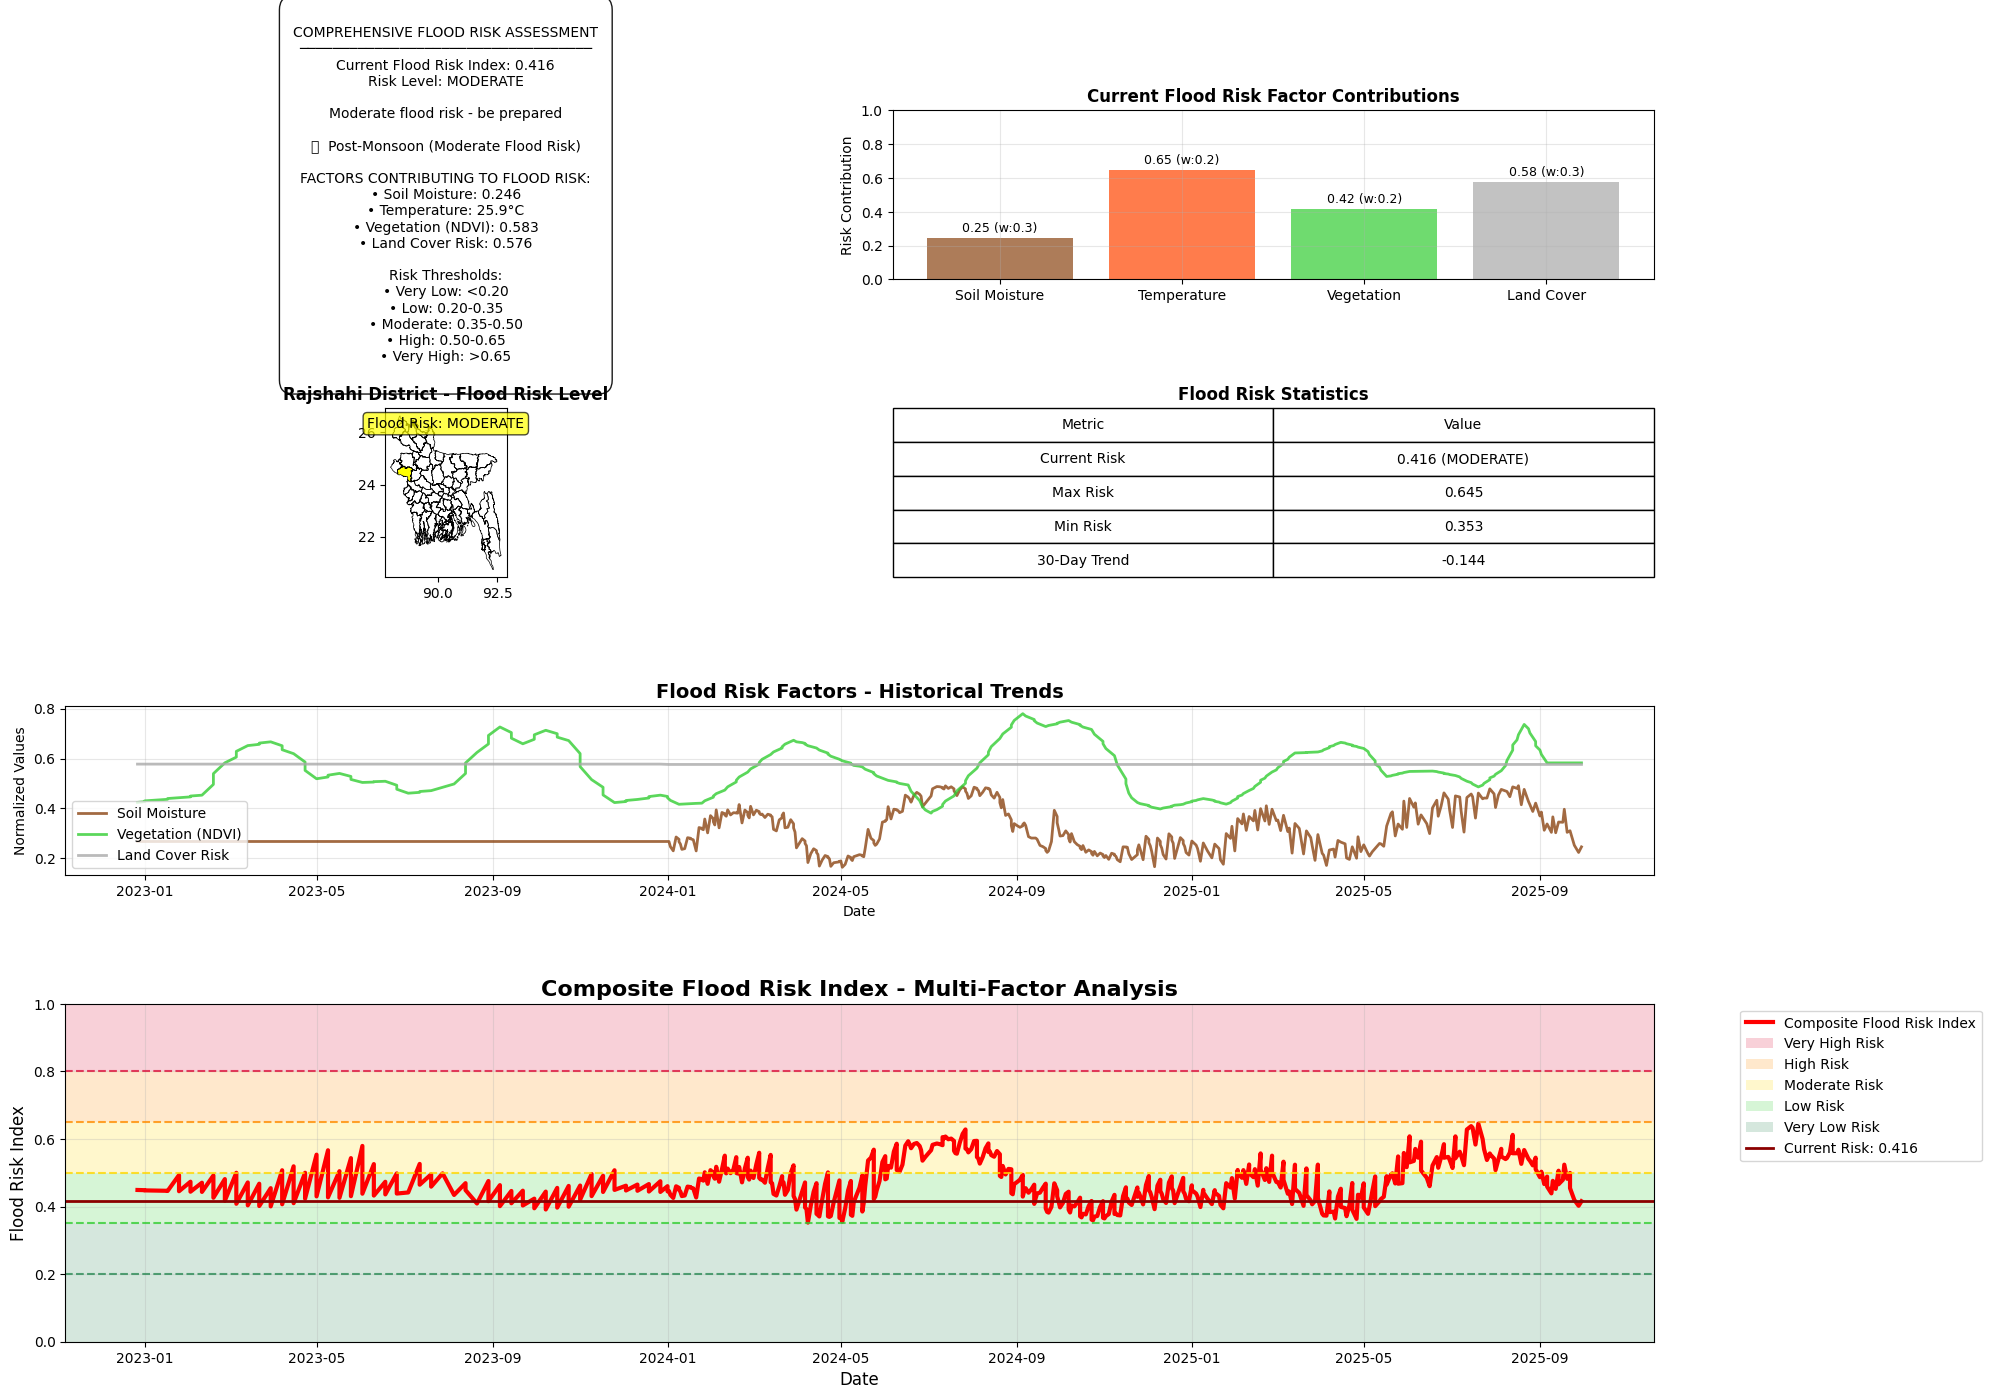


COMPREHENSIVE FLOOD RISK ASSESSMENT REPORT

🌊 FLOOD RISK OVERVIEW:
   Current Risk Index: 0.416
   Risk Level: MODERATE
   Moderate flood risk - be prepared

📊 RISK FACTOR ANALYSIS:
   Soil Moisture: 0.246 (Saturation Level)
   Temperature: 25.9°C (Rainfall Potential)
   Vegetation Index: 0.583 (Runoff Absorption)
   Land Cover Risk: 0.576 (Surface Impermeability)

📈 HISTORICAL CONTEXT:
   Maximum Recorded Risk: 0.645
   Minimum Recorded Risk: 0.353
   Average Risk: 0.472

🌧️  SEASONAL CONTEXT:
   🌤️  Post-Monsoon (Moderate Flood Risk)

🚨 RECOMMENDATIONS:
   • Increase monitoring frequency
   • Check flood protection equipment
   • Alert emergency response teams
   • Review evacuation routes

🔍 KEY OBSERVATIONS:

📋 METHODOLOGY:
   Composite Flood Risk Index calculated using:
   • Soil Moisture (30%): Higher saturation = higher risk
   • Temperature (20%): Extreme temps = rainfall potential
   • Vegetation Index (20%): Lower NDVI = higher runoff
   • Land Cover (30%): Urban/barren area

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from datetime import datetime

# -------------------------
# 1. Load All Datasets with Timezone Handling
# -------------------------

# Soil Moisture Data
soil_stat_file = f"{divison}/SPL3SMP-009-Statistics.csv"
soil_flag_file = f"{divison}/SPL3SMP-009-Soil-Moisture-Retrieval-Data-AM-retrieval-qual-flag-Statistics-QA.csv"
soil_lookup_file = f"{divison}/SPL3SMP-009-Soil-Moisture-Retrieval-Data-AM-retrieval-qual-flag-lookup.csv"

# Temperature Data
temp_stat_file = f"{divison}/MYD11A2-061-Statistics.csv"
temp_qc_file = f"{divison}/MYD11A2-061-QC-Day-Statistics-QA.csv"
temp_lookup_file = f"{divison}/MYD11A2-061-QC-Day-lookup.csv"

# Vegetation Data
veg_stat_file = f"{divison}/MOD13Q1-061-Statistics.csv"
veg_qc_file = f"{divison}/MOD13Q1-061-250m-16-days-VI-Quality-Statistics-QA.csv"
veg_lookup_file =  f"{divison}/MOD13Q1-061-250m-16-days-VI-Quality-lookup.csv"

# Land Cover Data
lc_stat_file = f"{divison}/MCD12Q1-061-LC-Type1-Statistics"
lc_qc_file = f"{divison}/MCD12Q1-061-QC-Statistics-QA"
lc_lookup_file = f"{divison}/MCD12Q1-061-QC-lookup"

# Load Soil Moisture Data
df_soil_stat = pd.read_csv(soil_stat_file)
df_soil_flag = pd.read_csv(soil_flag_file)
df_soil_lookup = pd.read_csv(soil_lookup_file)

# Load Temperature Data
df_temp_stat = pd.read_csv(temp_stat_file)
df_temp_qc = pd.read_csv(temp_qc_file)
df_temp_lookup = pd.read_csv(temp_lookup_file)

# Load Vegetation Data
df_veg_stat = pd.read_csv(veg_stat_file)
df_veg_qc = pd.read_csv(veg_qc_file)
df_veg_lookup = pd.read_csv(veg_lookup_file)

# Load Land Cover Data
df_lc_stat = pd.read_csv(lc_stat_file)
df_lc_qc = pd.read_csv(lc_qc_file)
df_lc_lookup = pd.read_csv(lc_lookup_file)

# Convert Date columns and ensure timezone-naive
def make_timezone_naive(df, date_column='Date'):
    """Convert datetime columns to timezone-naive"""
    df[date_column] = pd.to_datetime(df[date_column], errors="coerce")
    # If timezone-aware, convert to naive; if already naive, this does nothing
    if df[date_column].dt.tz is not None:
        df[date_column] = df[date_column].dt.tz_localize(None)
    return df

# Apply to all dataframes
df_soil_stat = make_timezone_naive(df_soil_stat)
df_soil_flag = make_timezone_naive(df_soil_flag)
df_temp_stat = make_timezone_naive(df_temp_stat)
df_temp_qc = make_timezone_naive(df_temp_qc)
df_veg_stat = make_timezone_naive(df_veg_stat)
df_veg_qc = make_timezone_naive(df_veg_qc)
df_lc_stat = make_timezone_naive(df_lc_stat)
df_lc_qc = make_timezone_naive(df_lc_qc)

# -------------------------
# 2. Preprocess Soil Moisture Data
# -------------------------
df_soil_stat_slim = df_soil_stat[["Date","Mean"]].copy()
df_soil_stat_slim['is_soil_moisture'] = (df_soil_stat_slim['Mean'] >= 0) & (df_soil_stat_slim['Mean'] <= 1)
df_soil_moisture = df_soil_stat_slim[df_soil_stat_slim['is_soil_moisture']].copy()
df_soil_moisture = df_soil_moisture[["Date","Mean"]].rename(columns={"Mean": "Soil_Moisture"})

# -------------------------
# 3. Preprocess Temperature Data
# -------------------------
df_temp_slim = df_temp_stat[["Date","Mean"]].rename(columns={"Mean": "Temperature"})

# -------------------------
# 4. Preprocess Vegetation Data
# -------------------------
df_veg_slim = df_veg_stat[["Date","Mean"]].rename(columns={"Mean": "NDVI"})

# -------------------------
# 5. Preprocess Land Cover Data for Flood Risk
# -------------------------
def calculate_land_cover_flood_risk(row):
    """
    Calculate flood risk based on land cover types
    Urban and barren areas have higher flood risk
    Forests and wetlands have lower flood risk
    """
    # High flood risk categories
    urban = row.get('(13) Urban and Built-up Lands', 0)
    barren = row.get('(16) Barren', 0)
    
    # Medium flood risk categories  
    cropland = row.get('(12) Croplands', 0)
    mosaic = row.get('(14) Cropland/Natural Vegetation Mosaic', 0)
    
    # Low flood risk categories (natural vegetation that absorbs water)
    forests = (row.get('(1) Evergreen Needleleaf Forests', 0) + 
               row.get('(2) Evergreen Broadleaf Forests', 0))
    natural = (row.get('(9) Savannas', 0) + 
               row.get('(10) Grasslands', 0) +
               row.get('(11) Permanent Wetlands', 0))
    
    total_area = urban + barren + cropland + mosaic + forests + natural + row.get('(17) Water Bodies', 0)
    
    if total_area == 0:
        return 0.5  # Default moderate risk
    
    # Weighted flood risk calculation
    flood_risk = (urban * 0.9 + barren * 0.8 + cropland * 0.6 + mosaic * 0.5 + 
                  forests * 0.2 + natural * 0.3) / total_area
    return min(flood_risk, 1.0)  # Cap at 1.0

df_lc_stat['Land_Cover_Risk'] = df_lc_stat.apply(calculate_land_cover_flood_risk, axis=1)
df_lc_slim = df_lc_stat[["Date","Land_Cover_Risk"]]

# -------------------------
# 6. Merge All Datasets with Timezone Handling
# -------------------------
# Create base dataframe with all dates (ensure all are timezone-naive)
all_dates = set()
for df in [df_soil_moisture, df_temp_slim, df_veg_slim, df_lc_slim]:
    dates = df['Date'].dropna().unique()
    all_dates.update(dates)

# Convert to sorted list of timezone-naive dates
all_dates_sorted = sorted([pd.Timestamp(date) for date in all_dates])
df_base = pd.DataFrame({'Date': all_dates_sorted})

# Merge all datasets
df_merged = df_base.merge(df_soil_moisture, on='Date', how='left')
df_merged = df_merged.merge(df_temp_slim, on='Date', how='left')
df_merged = df_merged.merge(df_veg_slim, on='Date', how='left')
df_merged = df_merged.merge(df_lc_slim, on='Date', how='left')

print(f"Merged dataset shape: {df_merged.shape}")
print(f"Date range: {df_merged['Date'].min()} to {df_merged['Date'].max()}")

# Handle missing values
# Forward fill land cover risk (it doesn't change frequently)
df_merged['Land_Cover_Risk'] = df_merged['Land_Cover_Risk'].fillna(method='ffill').fillna(method='bfill')

# Fill other missing values with interpolation
for column in ['Soil_Moisture', 'Temperature', 'NDVI']:
    df_merged[column] = df_merged[column].interpolate(method='linear', limit_direction='both')

# If there are still missing values, fill with column mean
for column in ['Soil_Moisture', 'Temperature', 'NDVI', 'Land_Cover_Risk']:
    df_merged[column] = df_merged[column].fillna(df_merged[column].mean())

# -------------------------
# 7. Calculate Composite Flood Risk Index
# -------------------------
def calculate_flood_risk_index(row):
    """
    Calculate composite flood risk index based on multiple factors
    """
    risk_components = []
    weights = []
    
    # 1. Soil Moisture (higher = higher flood risk)
    sm_risk = min(row['Soil_Moisture'] * 2, 1.0)  # Scale 0-0.5 to 0-1
    risk_components.append(sm_risk)
    weights.append(0.3)  # 30% weight
    
    # 2. Temperature (convert to Celsius and assess rainfall potential)
    temp_c = row['Temperature'] - 273.15
    # Higher temperatures can indicate convective rainfall potential in tropical regions
    temp_risk = max(0, min((temp_c - 25) / 15, 1.0))  # 25-40°C scale
    risk_components.append(temp_risk)
    weights.append(0.2)  # 20% weight
    
    # 3. NDVI (lower vegetation = higher runoff risk)
    ndvi_risk = 1.0 - min(max(row['NDVI'], 0), 1.0)  # Inverse relationship
    risk_components.append(ndvi_risk)
    weights.append(0.2)  # 20% weight
    
    # 4. Land Cover Risk (pre-calculated)
    lc_risk = row['Land_Cover_Risk']
    risk_components.append(lc_risk)
    weights.append(0.3)  # 30% weight
    
    # Calculate weighted average
    total_risk = sum(r * w for r, w in zip(risk_components, weights))
    return min(total_risk, 1.0)

df_merged['Flood_Risk_Index'] = df_merged.apply(calculate_flood_risk_index, axis=1)

# -------------------------
# 8. Flood Risk Classification
# -------------------------
FLOOD_RISK_THRESHOLDS = {
    'Very Low': 0.2,
    'Low': 0.35,
    'Moderate': 0.5,
    'High': 0.65,
    'Very High': 0.8
}

FLOOD_RISK_COLORS = {
    'Very Low': '#2E8B57',      # Sea Green
    'Low': '#32CD32',           # Lime Green  
    'Moderate': '#FFD700',      # Gold
    'High': '#FF8C00',         # Dark Orange
    'Very High': '#DC143C'     # Crimson
}

def classify_flood_risk(risk_index):
    if risk_index <= FLOOD_RISK_THRESHOLDS['Very Low']:
        return "VERY LOW", "Minimal flood risk - normal conditions"
    elif risk_index <= FLOOD_RISK_THRESHOLDS['Low']:
        return "LOW", "Low flood risk - monitor weather forecasts"
    elif risk_index <= FLOOD_RISK_THRESHOLDS['Moderate']:
        return "MODERATE", "Moderate flood risk - be prepared"
    elif risk_index <= FLOOD_RISK_THRESHOLDS['High']:
        return "HIGH", "High flood risk - take precautions"
    else:
        return "VERY HIGH", "Very high flood risk - immediate action needed"

current_risk = df_merged['Flood_Risk_Index'].iloc[-1] if len(df_merged) > 0 else 0
risk_status, risk_message = classify_flood_risk(current_risk)

# -------------------------
# 9. Seasonal Context
# -------------------------
current_month = pd.Timestamp.now().month
if current_month in [6, 7, 8, 9]:  # Monsoon season
    season_info = "🌧️  Monsoon Season (High Flood Risk Period)"
elif current_month in [10, 11]:  # Post-monsoon
    season_info = "🌤️  Post-Monsoon (Moderate Flood Risk)"
else:
    season_info = "☀️  Dry Season (Lower Flood Risk)"

# -------------------------
# 10. Enhanced Summary
# -------------------------
summary_text = f"""
COMPREHENSIVE FLOOD RISK ASSESSMENT
───────────────────────────────────
Current Flood Risk Index: {current_risk:.3f}
Risk Level: {risk_status}

{risk_message}

{season_info}

FACTORS CONTRIBUTING TO FLOOD RISK:
• Soil Moisture: {df_merged['Soil_Moisture'].iloc[-1]:.3f}
• Temperature: {(df_merged['Temperature'].iloc[-1]-273.15):.1f}°C
• Vegetation (NDVI): {df_merged['NDVI'].iloc[-1]:.3f}
• Land Cover Risk: {df_merged['Land_Cover_Risk'].iloc[-1]:.3f}

Risk Thresholds:
• Very Low: <{FLOOD_RISK_THRESHOLDS['Very Low']:.2f}
• Low: {FLOOD_RISK_THRESHOLDS['Very Low']:.2f}-{FLOOD_RISK_THRESHOLDS['Low']:.2f}
• Moderate: {FLOOD_RISK_THRESHOLDS['Low']:.2f}-{FLOOD_RISK_THRESHOLDS['Moderate']:.2f}
• High: {FLOOD_RISK_THRESHOLDS['Moderate']:.2f}-{FLOOD_RISK_THRESHOLDS['High']:.2f}
• Very High: >{FLOOD_RISK_THRESHOLDS['High']:.2f}
"""

# -------------------------
# 11. Enhanced Plot Layout
# -------------------------
fig = plt.figure(figsize=(20, 14))
gs = GridSpec(4, 2, height_ratios=[1, 1, 1, 2], width_ratios=[1, 1], figure=fig)

# --- Row 1, Col 1: Flood Risk Summary ---
ax0 = fig.add_subplot(gs[0, 0])
bg_colors = {
    'VERY LOW': '#E8F5E8',
    'LOW': '#F0F8E8', 
    'MODERATE': '#FFF8E1',
    'HIGH': '#FFE8E8',
    'VERY HIGH': '#FFE8E8'
}
ax0.set_facecolor(bg_colors.get(risk_status, '#FFFFFF'))
ax0.axis('off')
ax0.text(0.5, 0.5, summary_text, fontsize=10, ha='center', va='center',
         bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=1'))

# --- Row 1, Col 2: Risk Factors Breakdown ---
ax1 = fig.add_subplot(gs[0, 1])
factors = ['Soil Moisture', 'Temperature', 'Vegetation', 'Land Cover']
current_values = [
    df_merged['Soil_Moisture'].iloc[-1],
    (df_merged['Temperature'].iloc[-1]-273.15)/40,  # Normalized
    1 - df_merged['NDVI'].iloc[-1],  # Inverted for risk
    df_merged['Land_Cover_Risk'].iloc[-1]
]
weights = [0.3, 0.2, 0.2, 0.3]

colors = ['#8B4513', '#FF4500', '#32CD32', '#A9A9A9']
bars = ax1.bar(factors, current_values, color=colors, alpha=0.7)

# Add value labels
for bar, value, weight in zip(bars, current_values, weights):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.2f} (w:{weight})', ha='center', va='bottom', fontsize=9)

ax1.set_ylabel('Risk Contribution')
ax1.set_title('Current Flood Risk Factor Contributions', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3)

# --- Row 2, Col 1: Map Visualization ---
ax2 = fig.add_subplot(gs[1, 0])
try:
    gdf_bgd = gpd.read_file("Bangladesh map/gadm41_BGD_2.json")
    rajshahi = gdf_bgd[gdf_bgd["NAME_2"] == "Rajshahi"]
    gdf_bgd.boundary.plot(ax=ax2, color="black", linewidth=0.5)
    
    risk_colors = {
        'VERY LOW': 'green',
        'LOW': 'lightgreen',
        'MODERATE': 'yellow', 
        'HIGH': 'orange',
        'VERY HIGH': 'red'
    }
    rajshahi.plot(ax=ax2, color=risk_colors.get(risk_status, 'gray'))
    ax2.set_title("Rajshahi District - Flood Risk Level", fontsize=12, fontweight='bold')
    
    # Add risk indicator
    ax2.text(0.5, 0.95, f"Flood Risk: {risk_status}", 
             transform=ax2.transAxes, ha='center', va='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor=risk_colors.get(risk_status, 'white'), alpha=0.7))
except Exception as e:
    ax2.text(0.5, 0.5, "Map data not available", ha='center', va='center', fontsize=12)
    ax2.set_title("Rajshahi District", fontsize=12, fontweight='bold')

# --- Row 2, Col 2: Historical Statistics ---
ax3 = fig.add_subplot(gs[1, 1])
# Calculate 30-day trend safely
trend_value = 0
if len(df_merged) > 30:
    trend_value = df_merged['Flood_Risk_Index'].iloc[-1] - df_merged['Flood_Risk_Index'].iloc[-30]
else:
    trend_value = df_merged['Flood_Risk_Index'].iloc[-1] - df_merged['Flood_Risk_Index'].iloc[0] if len(df_merged) > 1 else 0

stats_data = {
    'Metric': ['Current Risk', 'Max Risk', 'Min Risk', '30-Day Trend'],
    'Value': [
        f"{current_risk:.3f} ({risk_status})",
        f"{df_merged['Flood_Risk_Index'].max():.3f}", 
        f"{df_merged['Flood_Risk_Index'].min():.3f}",
        f"{trend_value:+.3f}"
    ]
}
stats_df = pd.DataFrame(stats_data)
ax3.axis('off')
table = ax3.table(cellText=stats_df.values,
                 colLabels=stats_df.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
ax3.set_title('Flood Risk Statistics', fontsize=12, fontweight='bold')

# --- Row 3: Individual Factor Time Series ---
ax4 = fig.add_subplot(gs[2, :])
factors_to_plot = ['Soil_Moisture', 'NDVI', 'Land_Cover_Risk']
factor_names = ['Soil Moisture', 'Vegetation (NDVI)', 'Land Cover Risk']
colors = ['#8B4513', '#32CD32', '#A9A9A9']

for i, (factor, name, color) in enumerate(zip(factors_to_plot, factor_names, colors)):
    ax4.plot(df_merged['Date'], df_merged[factor], 
             label=name, color=color, linewidth=2, alpha=0.8)

ax4.set_title("Flood Risk Factors - Historical Trends", fontsize=14, fontweight='bold')
ax4.set_xlabel("Date")
ax4.set_ylabel("Normalized Values")
ax4.legend()
ax4.grid(True, alpha=0.3)

# --- Row 4: Composite Flood Risk Time Series ---
ax5 = fig.add_subplot(gs[3, :])

# Plot flood risk over time
ax5.plot(df_merged['Date'], df_merged['Flood_Risk_Index'], 
         color='red', linewidth=3, label='Composite Flood Risk Index')

# Add shaded regions for flood risk thresholds
y_min, y_max = 0, 1.0
threshold_ranges = [
    (FLOOD_RISK_THRESHOLDS['Very High'], y_max, FLOOD_RISK_COLORS['Very High'], 'Very High Risk'),
    (FLOOD_RISK_THRESHOLDS['High'], FLOOD_RISK_THRESHOLDS['Very High'], FLOOD_RISK_COLORS['High'], 'High Risk'),
    (FLOOD_RISK_THRESHOLDS['Moderate'], FLOOD_RISK_THRESHOLDS['High'], FLOOD_RISK_COLORS['Moderate'], 'Moderate Risk'),
    (FLOOD_RISK_THRESHOLDS['Low'], FLOOD_RISK_THRESHOLDS['Moderate'], FLOOD_RISK_COLORS['Low'], 'Low Risk'),
    (y_min, FLOOD_RISK_THRESHOLDS['Low'], FLOOD_RISK_COLORS['Very Low'], 'Very Low Risk')
]

for ymin, ymax, color, label in threshold_ranges:
    ax5.axhspan(ymin, ymax, facecolor=color, alpha=0.2, label=label)

# Add threshold lines
for threshold_name, threshold_value in FLOOD_RISK_THRESHOLDS.items():
    ax5.axhline(y=threshold_value, color=FLOOD_RISK_COLORS[threshold_name], 
                linestyle='--', alpha=0.8, linewidth=1.5)

# Add current risk marker
ax5.axhline(y=current_risk, color='darkred', linestyle='-', linewidth=2, 
           label=f'Current Risk: {current_risk:.3f}')

ax5.set_title("Composite Flood Risk Index - Multi-Factor Analysis", 
             fontsize=16, fontweight='bold')
ax5.set_xlabel("Date", fontsize=12)
ax5.set_ylabel("Flood Risk Index", fontsize=12)
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# -------------------------
# 12. Detailed Flood Risk Report
# -------------------------
print("\n" + "="*60)
print("COMPREHENSIVE FLOOD RISK ASSESSMENT REPORT")
print("="*60)

print(f"\n🌊 FLOOD RISK OVERVIEW:")
print(f"   Current Risk Index: {current_risk:.3f}")
print(f"   Risk Level: {risk_status}")
print(f"   {risk_message}")

print(f"\n📊 RISK FACTOR ANALYSIS:")
print(f"   Soil Moisture: {df_merged['Soil_Moisture'].iloc[-1]:.3f} (Saturation Level)")
print(f"   Temperature: {(df_merged['Temperature'].iloc[-1]-273.15):.1f}°C (Rainfall Potential)")
print(f"   Vegetation Index: {df_merged['NDVI'].iloc[-1]:.3f} (Runoff Absorption)")
print(f"   Land Cover Risk: {df_merged['Land_Cover_Risk'].iloc[-1]:.3f} (Surface Impermeability)")

print(f"\n📈 HISTORICAL CONTEXT:")
print(f"   Maximum Recorded Risk: {df_merged['Flood_Risk_Index'].max():.3f}")
print(f"   Minimum Recorded Risk: {df_merged['Flood_Risk_Index'].min():.3f}")
print(f"   Average Risk: {df_merged['Flood_Risk_Index'].mean():.3f}")

print(f"\n🌧️  SEASONAL CONTEXT:")
print(f"   {season_info}")

print(f"\n🚨 RECOMMENDATIONS:")
if risk_status == "VERY LOW":
    print("   • Normal conditions - maintain regular monitoring")
    print("   • Review drainage system maintenance schedules")
elif risk_status == "LOW":
    print("   • Monitor weather forecasts regularly")
    print("   • Ensure drainage systems are clear")
    print("   • Review emergency contact lists")
elif risk_status == "MODERATE":
    print("   • Increase monitoring frequency")
    print("   • Check flood protection equipment")
    print("   • Alert emergency response teams")
    print("   • Review evacuation routes")
elif risk_status == "HIGH":
    print("   • Activate flood monitoring protocols")
    print("   • Prepare emergency supplies")
    print("   • Issue public advisories")
    print("   • Prepare evacuation centers")
else:  # VERY HIGH
    print("   • IMMEDIATE ACTION REQUIRED")
    print("   • Activate emergency response plans")
    print("   • Issue evacuation orders if necessary")
    print("   • Deploy emergency services")
    print("   • Continuous monitoring and public updates")

print(f"\n🔍 KEY OBSERVATIONS:")
if df_merged['Soil_Moisture'].iloc[-1] > 0.4:
    print("   ⚠️  High soil moisture indicates ground saturation")
if (df_merged['Temperature'].iloc[-1]-273.15) > 35:
    print("   ⚠️  High temperature may indicate convective rainfall potential")
if df_merged['NDVI'].iloc[-1] < 0.3:
    print("   ⚠️  Low vegetation cover increases runoff risk")
if df_merged['Land_Cover_Risk'].iloc[-1] > 0.6:
    print("   ⚠️  Urban/barren land cover increases flood vulnerability")

print(f"\n📋 METHODOLOGY:")
print("   Composite Flood Risk Index calculated using:")
print("   • Soil Moisture (30%): Higher saturation = higher risk")
print("   • Temperature (20%): Extreme temps = rainfall potential")
print("   • Vegetation Index (20%): Lower NDVI = higher runoff")
print("   • Land Cover (30%): Urban/barren areas = higher risk")